Number of benign images: 1800
Number of malignant images: 1497


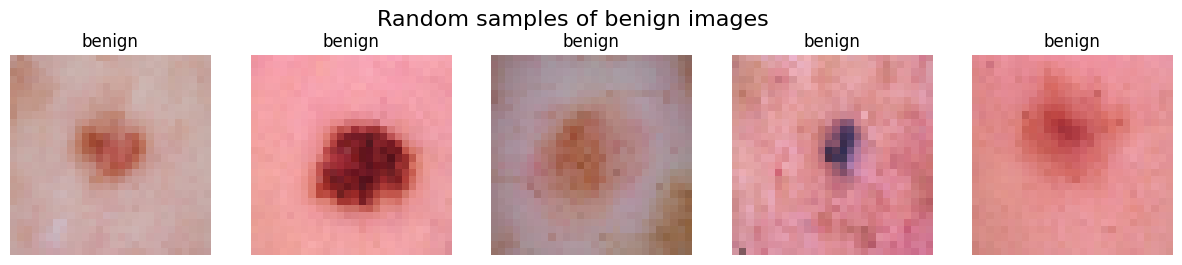

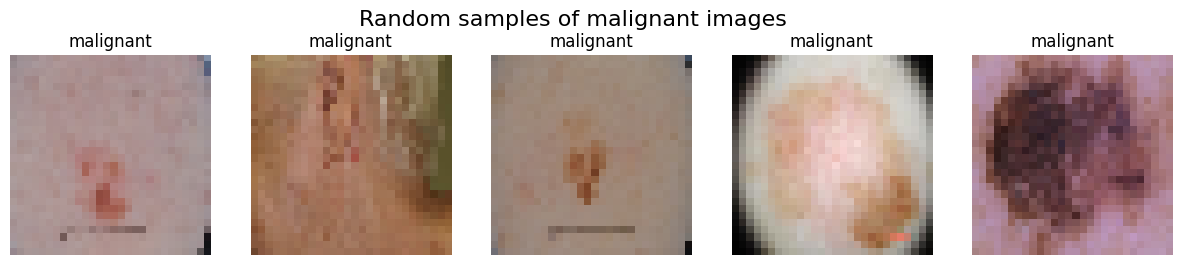

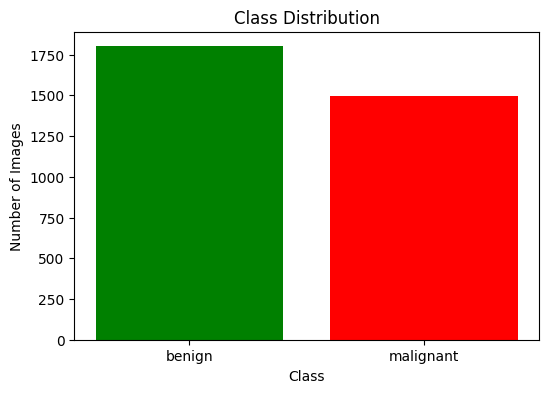

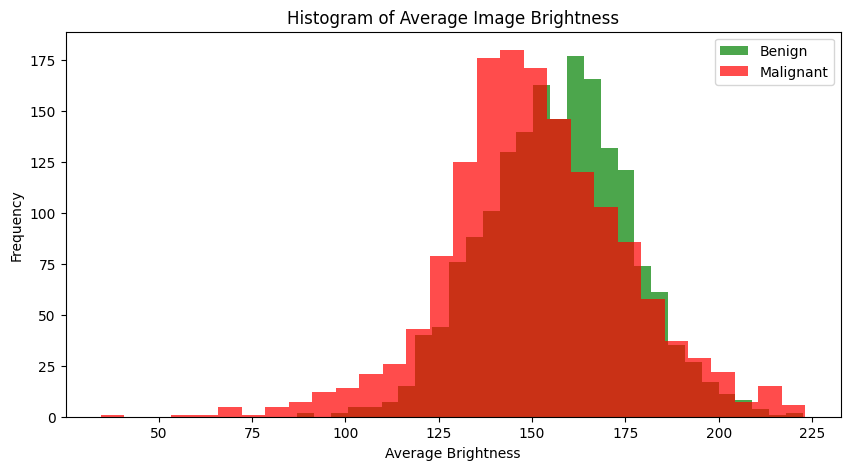

In [1]:
import os
import glob
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

benign_path = '/kaggle/input/skin-cancer-isic-images/benign'
malignant_path = '/kaggle/input/skin-cancer-isic-images/malignant'

benign_files = glob.glob(os.path.join(benign_path, '*'))
malignant_files = glob.glob(os.path.join(malignant_path, '*'))

IMG_HEIGHT, IMG_WIDTH = 28, 28

def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: unable to read image {img_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img.astype("float32") / 255.0
    return img

images = []
labels = []

for img_path in benign_files:
    img = load_and_preprocess_image(img_path)
    if img is not None:
        images.append(img)
        labels.append('benign')

for img_path in malignant_files:
    img = load_and_preprocess_image(img_path)
    if img is not None:
        images.append(img)
        labels.append('malignant')

num_benign = labels.count('benign')
num_malignant = labels.count('malignant')
print(f"Number of benign images: {num_benign}")
print(f"Number of malignant images: {num_malignant}")

def display_random_samples(class_label, sample_count=5):
    indices = [i for i, lab in enumerate(labels) if lab == class_label]
    sample_indices = random.sample(indices, min(sample_count, len(indices)))
    
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, sample_count, i+1)
        plt.imshow(images[idx])
        plt.title(f"{class_label}")
        plt.axis('off')
    plt.suptitle(f"Random samples of {class_label} images", fontsize=16)
    plt.show()

display_random_samples('benign')
display_random_samples('malignant')

plt.figure(figsize=(6,4))
classes = ['benign', 'malignant']
counts = [num_benign, num_malignant]
plt.bar(classes, counts, color=['green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

def compute_avg_brightness(img):
    gray = cv2.cvtColor((img*255).astype("uint8"), cv2.COLOR_RGB2GRAY)
    return np.mean(gray)

brightness_benign = [compute_avg_brightness(images[i]) for i, lab in enumerate(labels) if lab == 'benign']
brightness_malignant = [compute_avg_brightness(images[i]) for i, lab in enumerate(labels) if lab == 'malignant']

plt.figure(figsize=(10,5))
plt.hist(brightness_benign, bins=30, alpha=0.7, label='Benign', color='green')
plt.hist(brightness_malignant, bins=30, alpha=0.7, label='Malignant', color='red')
plt.title('Histogram of Average Image Brightness')
plt.xlabel('Average Brightness')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Initial Train class distribution:
{'benign': 1440, 'malignant': 1197}

Augmenting each class by 50% of its current samples...
Class 'benign': Original count = 1440, generating 720 augmented samples.
Class 'malignant': Original count = 1197, generating 598 augmented samples.

After first round augmentation, class distribution:
{'benign': 2160, 'malignant': 1795}

Balancing classes to reach a target of 2160 samples per class...
Class 'benign': current count = 2160, need 0 additional samples.
Class 'malignant': current count = 1795, need 365 additional samples.

Final balanced training set distribution:
{'benign': 2160, 'malignant': 2160}


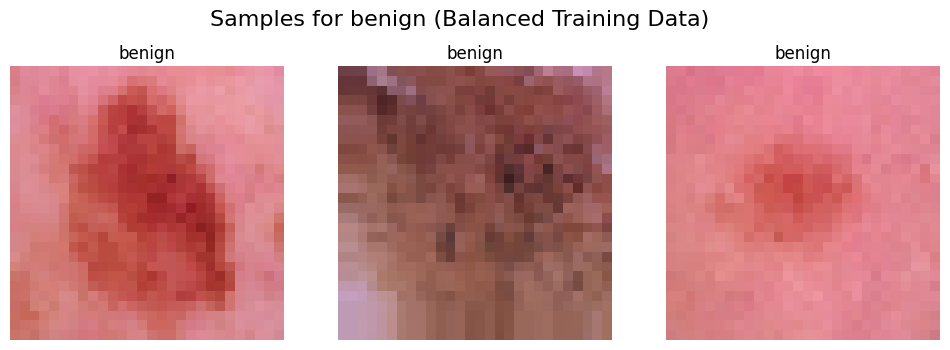

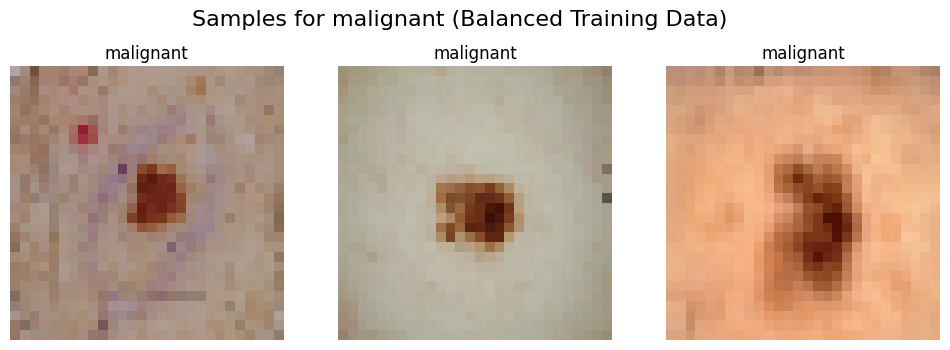

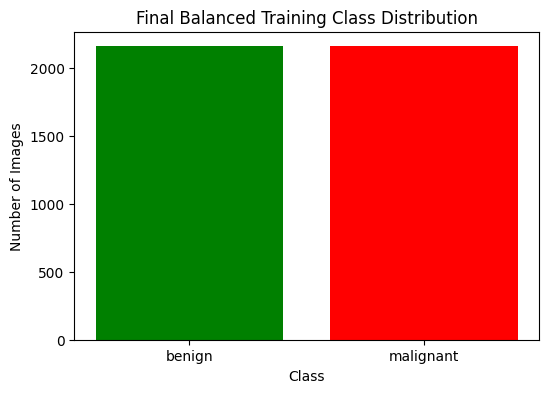

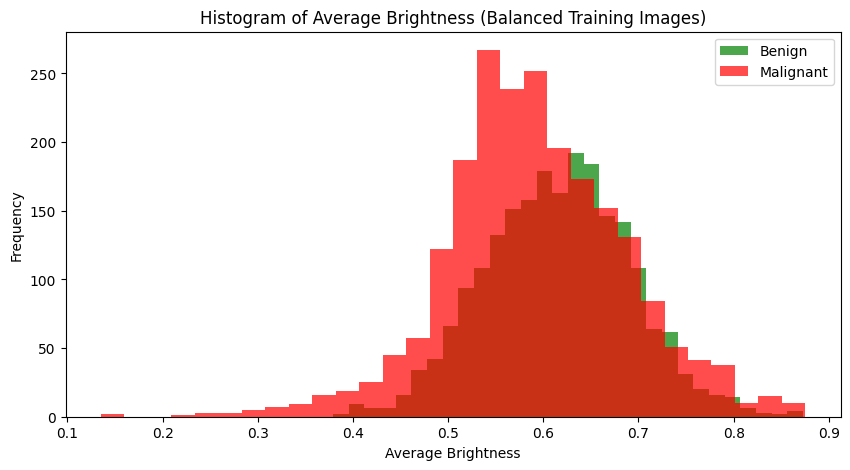

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

images = np.array(images)
labels = np.array(labels)

# --------------------------
# Split Data into Train and Test Sets
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)

print("Initial Train class distribution:")
(unique, counts) = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

# --------------------------
# Define Data Augmentation Generator
# --------------------------
datagen = ImageDataGenerator(
    rotation_range=15,            # random rotations ±15°
    width_shift_range=0.1,        # horizontal shifts ±10%
    height_shift_range=0.1,       # vertical shifts ±10%
    shear_range=0.1,              # shear intensity ±10%
    zoom_range=0.05,              # zoom ±5%
    horizontal_flip=True,         # random horizontal flips
    vertical_flip=True,           # random vertical flips
    fill_mode='nearest'
)

# --------------------------
# First Round: Augment a Fixed Percentage of Training Data for Each Class
# --------------------------
# Set the augmentation percentage (e.g., 50 means 50% of the current count per class)
augmentation_percentage = 50

X_train_augmented = list(X_train)
y_train_augmented = list(y_train)

# For each class, compute number of augmentations to generate from original training data
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("\nAugmenting each class by {}% of its current samples...".format(augmentation_percentage))
for class_label, count in zip(unique_classes, class_counts):
    num_aug = int(count * augmentation_percentage / 100)
    class_indices = np.where(y_train == class_label)[0]
    
    print(f"Class '{class_label}': Original count = {count}, generating {num_aug} augmented samples.")
    
    for _ in range(num_aug):
        idx = random.choice(class_indices)
        img = X_train[idx]
        img_expanded = np.expand_dims(img, axis=0)
        aug_iter = datagen.flow(img_expanded, batch_size=1, shuffle=False)
        aug_img = next(aug_iter)[0]
        X_train_augmented.append(aug_img)
        y_train_augmented.append(class_label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

print("\nAfter first round augmentation, class distribution:")
(unique, counts) = np.unique(y_train_augmented, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

# --------------------------
# Second Round: Further Augment Underrepresented Classes to Equalize the Dataset
# --------------------------
# Determine the target count (maximum count among classes)
target_count = max(class_distribution.values())

print("\nBalancing classes to reach a target of {} samples per class...".format(target_count))
X_train_balanced = list(X_train_augmented)
y_train_balanced = list(y_train_augmented)

unique_classes = np.unique(y_train_augmented)
for class_label in unique_classes:
    current_count = np.sum(y_train_augmented == class_label)
    augment_needed = target_count - current_count
    
    print(f"Class '{class_label}': current count = {current_count}, need {augment_needed} additional samples.")
    
    if augment_needed > 0:
        class_indices = np.where(y_train_augmented == class_label)[0]
        while augment_needed > 0:
            idx = random.choice(class_indices)
            img = X_train_augmented[idx]
            img_expanded = np.expand_dims(img, axis=0)
            aug_iter = datagen.flow(img_expanded, batch_size=1, shuffle=False)
            aug_img = next(aug_iter)[0]
            X_train_balanced.append(aug_img)
            y_train_balanced.append(class_label)
            augment_needed -= 1

X_train_balanced = np.array(X_train_balanced)
y_train_balanced = np.array(y_train_balanced)

print("\nFinal balanced training set distribution:")
(unique, counts) = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))

# --------------------------
# Display Some Augmented Samples for Each Class
# --------------------------
def display_augmented_samples(class_label, sample_count=3):
    indices = [i for i, lab in enumerate(y_train_balanced) if lab == class_label]
    sample_indices = np.random.choice(indices, min(sample_count, len(indices)), replace=False)
    plt.figure(figsize=(sample_count * 4, 4))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, sample_count, i+1)
        plt.imshow(X_train_balanced[idx])
        plt.title(f"{class_label}")
        plt.axis('off')
    plt.suptitle(f"Samples for {class_label} (Balanced Training Data)", fontsize=16)
    plt.show()

display_augmented_samples('benign', sample_count=3)
display_augmented_samples('malignant', sample_count=3)

# --------------------------
# Additional EDA: Plot the Balanced Class Distribution
# --------------------------
plt.figure(figsize=(6,4))
classes = list(np.unique(y_train_balanced))
counts = [np.sum(y_train_balanced == cl) for cl in classes]
plt.bar(classes, counts, color=['green', 'red'])
plt.title('Final Balanced Training Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

def compute_avg_brightness(img):
    gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    return np.mean(gray)

brightness_benign = [compute_avg_brightness(X_train_balanced[i]) for i, lab in enumerate(y_train_balanced) if lab == 'benign']
brightness_malignant = [compute_avg_brightness(X_train_balanced[i]) for i, lab in enumerate(y_train_balanced) if lab == 'malignant']

plt.figure(figsize=(10,5))
plt.hist(brightness_benign, bins=30, alpha=0.7, label='Benign', color='green')
plt.hist(brightness_malignant, bins=30, alpha=0.7, label='Malignant', color='red')
plt.title('Histogram of Average Brightness (Balanced Training Images)')
plt.xlabel('Average Brightness')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

BATCH_SIZE = 32

# Convert labels to numeric values (0 for 'benign' and 1 for 'malignant')
y_train_balanced = np.array([0 if lab=='benign' else 1 for lab in y_train_balanced])
y_test = np.array([0 if lab=='benign' else 1 for lab in y_test])

# -------------------------------
# 3. Model 1: Paper’s Model (Modified for Binary Classification)
# -------------------------------
def build_model_1(input_shape):
    model = models.Sequential(name="Article_Model_Modified")
    
    # conv2d_4: (None, 28, 28, 16) with 448 parameters
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    # max_pooling2d_4: (None, 14, 14, 16)
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    # conv2d_5: (None, 14, 14, 32) with 4,640 parameters
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    # max_pooling2d_5: (None, 7, 7, 32)
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    # conv2d_6: (None, 7, 7, 64) with 18,496 parameters
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    # max_pooling2d_6: (None, 4, 4, 64)
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    # conv2d_7: (None, 4, 4, 128) with 73,856 parameters
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    # max_pooling2d_7: (None, 2, 2, 128)
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    # Flatten layer: (None, 512)
    model.add(layers.Flatten())
    
    # dense_3: 64 neurons, 32,832 parameters
    model.add(layers.Dense(64, activation='relu'))
    # dense_4: 32 neurons, 2,080 parameters
    model.add(layers.Dense(32, activation='relu'))
    
    # For binary classification, output layer with 1 neuron
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

input_shape = X_train_balanced.shape[1:]
model1 = build_model_1(input_shape)
model1.summary()

# Compile model1
model1.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Define callbacks per Algorithm 1
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3)

# Train model1 using your preloaded training data
history_model1 = model1.fit(X_train_balanced, y_train_balanced,
                            validation_data=(X_test, y_test),
                            epochs=50,
                            batch_size=BATCH_SIZE,
                            callbacks=[early_stop, reduce_lr])

# Evaluate model1 on test data
loss1, acc1 = model1.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Model 1 - Test Loss: {loss1:.4f}, Test Accuracy: {acc1:.4f}")

# -------------------------------
# 4. Model 2: Enhanced Model 
# -------------------------------
def build_model_2(input_shape):
    model = models.Sequential(name="Enhanced_CNN_Model")
    
    # Block 1: Two Conv layers with BatchNorm and ReLU, then MaxPooling & Dropout
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.25))
    
    # Block 2: Increase filters and repeat
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.25))
    
    # Block 3: Further increase filters for deeper features
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.25))
    
    # Flatten and Dense layers for classification
    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(64))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    
    # Final output layer for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

model2 = build_model_2(input_shape)
model2.summary()

# Compile model2
model2.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Callbacks for model2
early_stop_2 = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_2 = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3)

# Train model2 using the preloaded data
history_model2 = model2.fit(X_train_balanced, y_train_balanced,
                            validation_data=(X_test, y_test),
                            epochs=50,
                            batch_size=BATCH_SIZE,
                            callbacks=[early_stop_2, reduce_lr_2])

# Evaluate model2 on test data
loss2, acc2 = model2.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Model 2 - Test Loss: {loss2:.4f}, Test Accuracy: {acc2:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Article_Model_Modified"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,385 (517.13 KB)

 Trainable params: 132,385 (517.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6100 - loss: 0.6538 - val_accuracy: 0.7864 - val_loss: 0.4345 - learning_rate: 0.0010
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7882 - loss: 0.4345 - val_accuracy: 0.8000 - val_loss: 0.3902 - learning_rate: 0.0010
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7925 - loss: 0.4182 - val_accuracy: 0.8045 - val_loss: 0.3783 - learning_rate: 0.0010
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8129 - loss: 0.3827 - val_accuracy: 0.8303 - val_loss: 0.3509 - learning_rate: 0.0010
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8361 - loss: 0.3558 - val_accuracy: 0.8212 - val_loss: 0.3364 - learning_rate: 0.0010
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8537 - loss: 0.3169 - val_accuracy: 0.8333 - val_loss: 0.3507 - learning_rate: 0.0010
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8541 - loss: 0.3182 -

Model: "Enhanced_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 7, 7, 128)           │              

 Total params: 831,137 (3.17 MB)

 Trainable params: 829,601 (3.16 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7028 - loss: 0.6315 - val_accuracy: 0.5455 - val_loss: 2.1521 - learning_rate: 0.0010
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7737 - loss: 0.4564 - val_accuracy: 0.6303 - val_loss: 1.1672 - learning_rate: 0.0010
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8016 - loss: 0.4156 - val_accuracy: 0.7864 - val_loss: 0.4439 - learning_rate: 0.0010
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8193 - loss: 0.3953 - val_accuracy: 0.8470 - val_loss: 0.3490 - learning_rate: 0.0010
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8254 - loss: 0.3722 - val_accuracy: 0.8242 - val_loss: 0.3980 - learning_rate: 0.0010
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8154 - loss: 0.3927 - val_accuracy: 0.7909 - val_loss: 0.4030 - learning_rate: 0.0010
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8250 - loss: 0.3507 

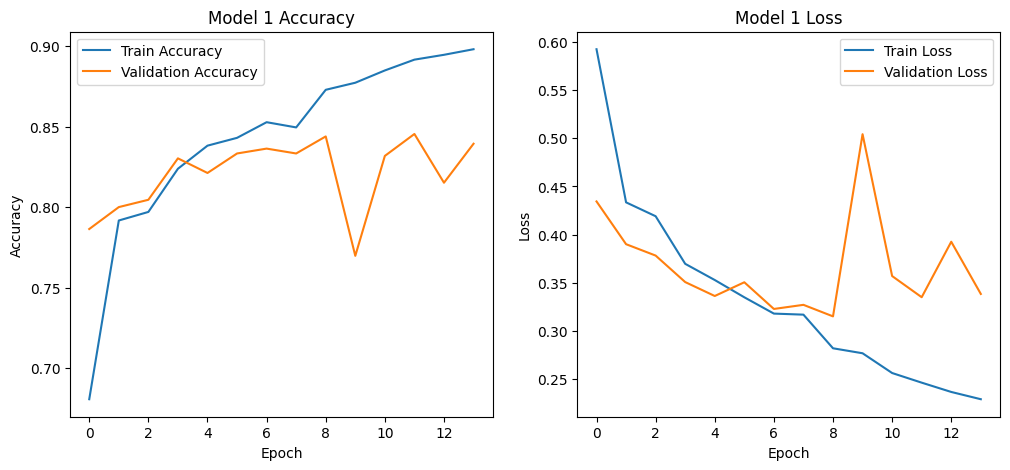

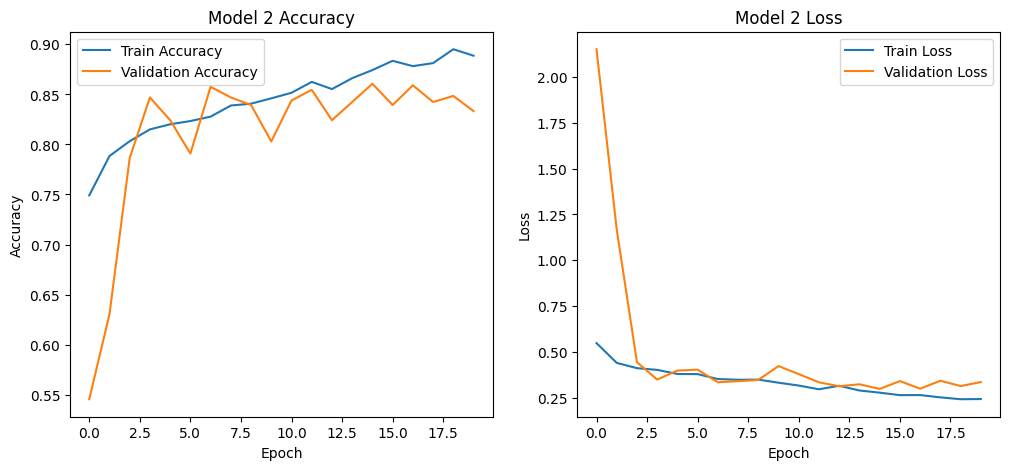

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


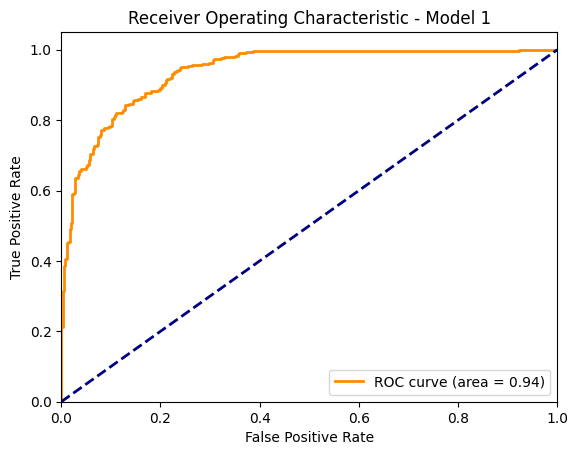

--- Model 1 Classification Report ---
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       360
           1       0.79      0.90      0.84       300

    accuracy                           0.84       660
   macro avg       0.85      0.85      0.84       660
weighted avg       0.85      0.84      0.84       660

--- Model 1 Confusion Matrix ---
[[287  73]
 [ 30 270]]
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step 


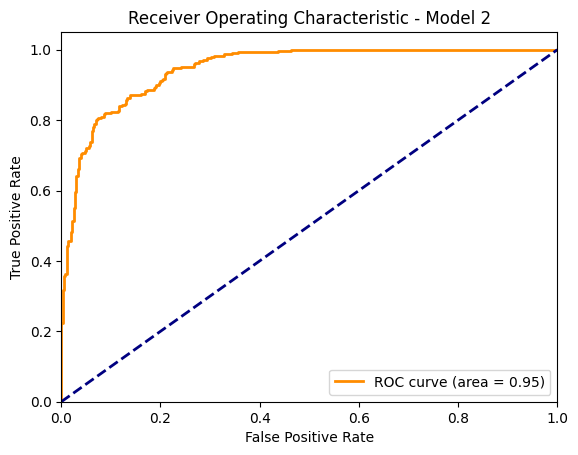

--- Model 2 Classification Report ---
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       360
           1       0.83      0.87      0.85       300

    accuracy                           0.86       660
   macro avg       0.86      0.86      0.86       660
weighted avg       0.86      0.86      0.86       660

--- Model 2 Confusion Matrix ---
[[307  53]
 [ 39 261]]


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# --- Plot Training Curves ---
def plot_training_curves(history, model_name):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot curves for Model 1 and Model 2
plot_training_curves(history_model1, 'Model 1')
plot_training_curves(history_model2, 'Model 2')

# --- Compute Predictions and ROC Curve for a Given Model ---
def plot_roc_and_metrics(model, X_test, y_test, model_name):
    y_pred_prob = model.predict(X_test).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f"--- {model_name} Classification Report ---")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"--- {model_name} Confusion Matrix ---")
    print(cm)
    
    # Analysis:
    # - Accuracy: overall percentage of correct predictions.
    # - Precision: the percentage of positive predictions that are correct.
    # - Recall: the percentage of actual positives correctly identified.
    # - F1-score: the harmonic mean of precision and recall, balancing the two.
    # The ROC curve and its AUC indicate the model's ability to distinguish
    # between the two classes at various thresholds.

plot_roc_and_metrics(model1, X_test, y_test, 'Model 1')

plot_roc_and_metrics(model2, X_test, y_test, 'Model 2')
